In [1]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt

In [2]:
def show_image(image,format=cv2.COLOR_HSV2RGB):
    return plt.imshow(cv2.cvtColor(image, format))

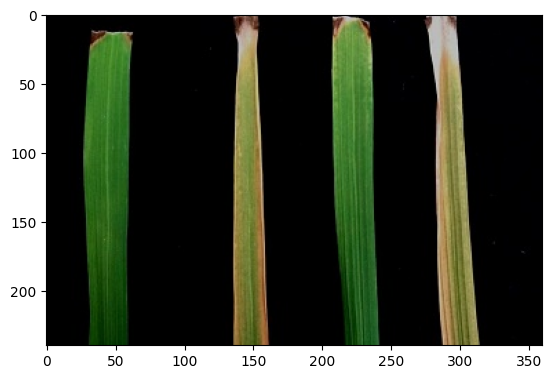

In [3]:
image = cv2.imread("./leaf1.jpg")
show_image(image,format=cv2.COLOR_BGR2RGB)

In [4]:
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

In [5]:
green_lower = np.array([25, 52, 72], np.uint8) 
green_upper = np.array([102, 255, 255], np.uint8) 
green_mask = cv2.inRange(hsv_image, green_lower, green_upper)

In [6]:
res_green = cv2.bitwise_and(hsv_image, hsv_image, mask = green_mask) 

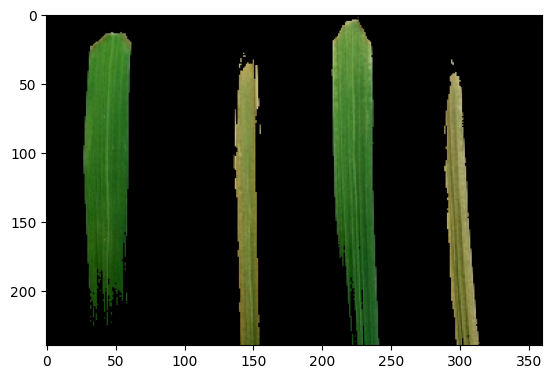

In [7]:
show_image(res_green)

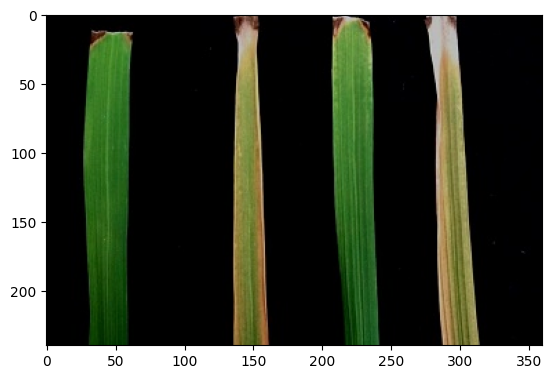

In [8]:
def draw_contours(image, mask,draw_rect = True):
    image = image.copy()
    img_width,img_height = image.shape[:2]
    MIN_AREA = .2*img_width*img_height
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if (hierarchy[0, i, 3] == -1) and area>MIN_AREA:
            # This contour is not inside another contour, so process it
            if draw_rect:
                x, y, w, h = cv2.boundingRect(contour) 
                image = cv2.rectangle(image, (x, y), (x + w, y + h), (1,1,1), 2) 
            else:
                contour_mask = np.zeros(image.shape[:2],dtype=np.uint8)
                cv2.drawContours(contour_mask, [contour], -1, 255, thickness=cv2.FILLED)
                image = cv2.bitwise_and(image, image, mask=contour_mask)

    return image

show_image(draw_contours(hsv_image,green_mask))

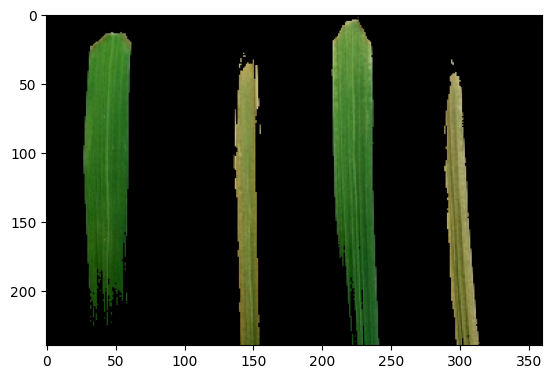

In [9]:
masked_image = draw_contours(res_green,green_mask,draw_rect=False)
show_image(masked_image)

In [10]:
def rgb_to_hsv(rgb):
    # Normalize RGB values to the range [0, 1]
    r, g, b = [x / 255.0 for x in rgb]

    # Find the minimum and maximum values
    min_val = min(r, g, b)
    max_val = max(r, g, b)
    delta = max_val - min_val

    # Calculate Hue
    if delta == 0:
        hue = 0
    elif max_val == r:
        hue = 60 * (((g - b) / delta) % 6)
    elif max_val == g:
        hue = 60 * (((b - r) / delta) + 2)
    elif max_val == b:
        hue = 60 * (((r - g) / delta) + 4)

    # Calculate Saturation
    saturation = 0 if max_val == 0 else delta / max_val

    # Calculate Value
    value = max_val

    # Adjust hue to be in the range [0, 360]
    hue = (hue + 360) % 360

    return (hue, saturation, value)



In [11]:
unique_colors = np.unique(masked_image.reshape((-1, 3)), axis=0)

In [12]:
def mode_of_image(image):
    # Reshape the image to a 2D array of RGB values
    reshaped_image = image.reshape((-1, 3))

    # Filter out black pixels (assuming black is [0, 0, 0] in RGB)
    non_black_pixels = reshaped_image[np.any(reshaped_image != [0, 0, 0], axis=1)]

    # Find unique values and their counts for non-black pixels
    unique_values, counts = np.unique(non_black_pixels, axis=0, return_counts=True)

    # Find the index/indices of the maximum count(s)
    max_count_indices = np.where(counts == counts.max())[0]

    # The mode(s) is/are the corresponding unique value(s)
    modes = unique_values[max_count_indices]

    return np.mean(modes,axis=0).astype(np.uint8)

In [13]:
mode_of_image(masked_image)

array([ 54, 172, 114], dtype=uint8)

In [14]:
target_colors = [
    (174,249,101),
    (133,204,64),
    (104,168,42),
    (64,115,15),
    (33,62,5)
]

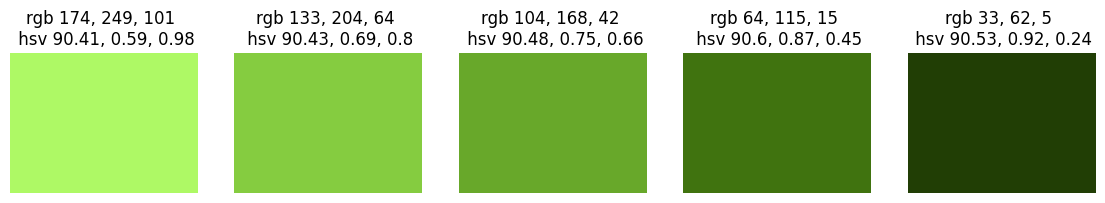

In [15]:
plt.figure(figsize=(14, 5))

height, width = 300, 400
for index,color in enumerate(target_colors):
    plt.subplot(1, len(target_colors), index+1)
    image = np.full((height, width, 3), color, dtype=np.uint8)
    plt.imshow(image)
    plt.title(f'rgb {color[0]}, {color[1]}, {color[2]} \n hsv {", ".join([str(round(c,2)) for  c in rgb_to_hsv(color)])}')
    plt.axis('off')

In [16]:
def group_color_hsv(input_color):
    # Convert colors to HSV
    color_hsv = rgb_to_hsv(input_color)
    # Find the closest target color in HSV space
    closest_color_index = np.argmin(np.linalg.norm(np.array(target_colors) - color_hsv, axis=1))
    return closest_color_index

In [17]:
group_color_hsv(mode_of_image(masked_image))

4